In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import seaborn as sns
from io import StringIO
from scipy.optimize import curve_fit
from typing import Tuple

In [3]:
def download_data():
    data_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
    url_req = requests.get(data_url).content
    covid_timeseries = pd.read_csv(StringIO(url_req.decode('utf-8')))
    return covid_timeseries.rename(columns={"Province/State": "province_state",
                                            "Country/Region": "country_region",
                                            "Lat": "lat",
                                            "Long": "long"})

In [48]:
def melt_data(covid_df: pd.DataFrame) -> pd.DataFrame:
    melted = (
        covid_df
        .melt(id_vars=['country_region', 'province_state', 'lat', 'long'],
              var_name="date", value_name="cases")
    )
    melted['date'] = melted['date'].astype('datetime64[ns]')
    return melted

In [44]:
def exp_fit(x, a, b, c):
    return a * np.exp(b * x) + c

In [57]:
def calc_country_fit(country: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    x = country['cases'].reset_index(drop=True).index.values
    y = country['cases'].values

    country_vars, country_cov = curve_fit(exp_fit, x, y)
    return x, y, country_vars, country_cov

In [83]:
def plot_fit(country: pd.DataFrame):
    cases_gt0 = country.query('cases > 0').reset_index()
    country_name = cases_gt0['country_region'].iloc[0]
    x, y, country_vars, country_cov = calc_country_fit(cases_gt0)
    print(country_vars)
    doubling_time = np.log(2) / country_vars[1]
    doubling_text = r'$t_{1/2 \ \mathrm{(exp. fit)}} = %.2f \ \mathrm{days}$' % doubling_time
    max_y = np.amax(y) // 10
    plt.figure()
    plt.plot(cases_gt0['date'].values, cases_gt0['cases'].values, 'b.')
    plt.plot(cases_gt0['date'], exp_fit(x, *country_vars), 'r-', label='Exp. fit')
    plt.title(f'COVID-19 cases in {country_name}')
    plt.xlabel('Date')
    plt.ylabel('Cases')
    plt.text(cases_gt0['date'].iloc[0], max_y * 9,
             doubling_text, {'color': 'r', 'fontsize': 16})
    plt.show()

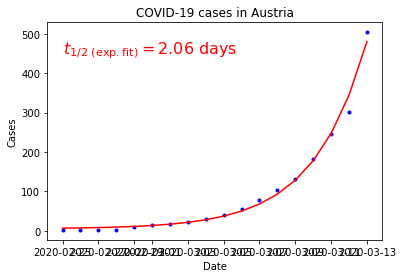

In [80]:
raw_df = download_data()
countries_melted = melt_data(raw_df)
at_data = countries_melted.query('country_region == "Austria"').drop(columns='province_state').reset_index(drop=True)
plot_fit(at_data)

[0.04536041 0.2305433  2.15247326]


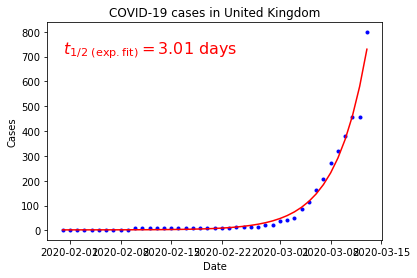

In [88]:
uk_data = (
    countries_melted
    .query('country_region == "United Kingdom" & province_state == "United Kingdom"')
    .drop(columns='province_state')
    .reset_index(drop=True)
)
plot_fit(uk_data)

[1.15638474e-14 9.99999995e-01 2.81672512e+01]


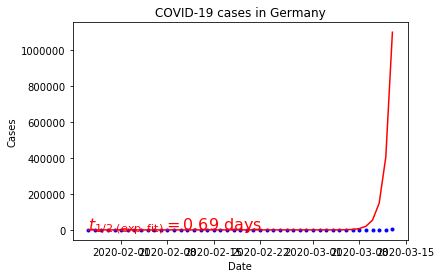

In [84]:
de_data = (
    countries_melted
    .query('country_region == "Germany"')
    .drop(columns='province_state')
    .reset_index(drop=True)
)
plot_fit(de_data)

In [103]:
plot_countries = ['Italy', 'Korea, South', 'Germany', 'Austria', 'United Kingdom',
                  'Switzerland', 'France', 'US', 'Denmark']

In [104]:
sub_sel = countries_melted[countries_melted['country_region'].isin(plot_countries)]
country_sum = sub_sel.groupby(['country_region', 'date'])['cases'].agg(np.sum).reset_index()

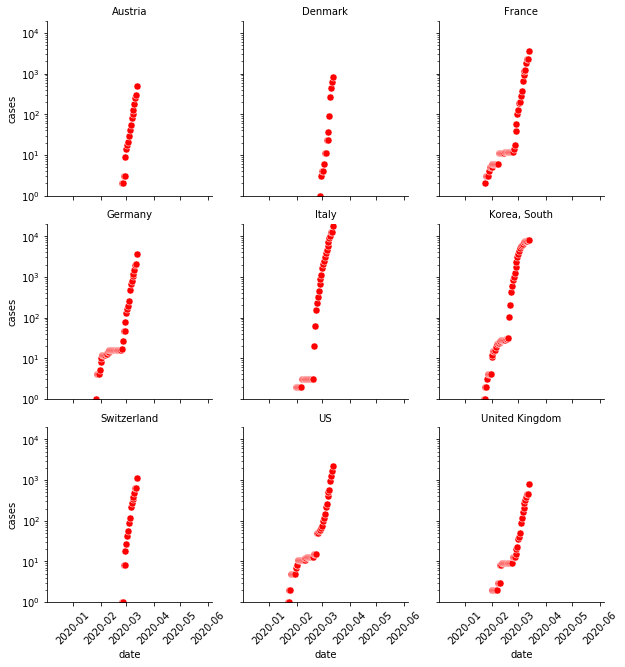

In [117]:
kws = dict(s=50, linewidth=.5, edgecolor="w")
g = sns.FacetGrid(country_sum.query('cases > 0'), col='country_region', col_wrap=3, ylim=(1, 20000))
g = (
    g.map(plt.scatter, 'date', 'cases', color='r', **kws)
    .set(yscale='log')
    .set_titles('{col_name}')
    .set_xticklabels(rotation=45)
)